In [40]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import math
import gensim
from gensim import corpora
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train = pd.read_csv("./gdrive/MyDrive/quora question pair/train.csv")
train.drop_duplicates(inplace=True)
train.dropna(inplace=True)


In [32]:
a = []
b = []
print(train.shape)
for i in range(train.shape[0]):
  try:
    a.append(train.question1[i].split(" "))
    b.append(train.question2[i].split(" "))
  except:
    pass

bowTest = corpora.Dictionary(a + b)
print(len(bowTest.token2id))


(404287, 6)
232540


Number of unique questions:  537929


Text(0, 0.5, 'Number of questions with y apperances')

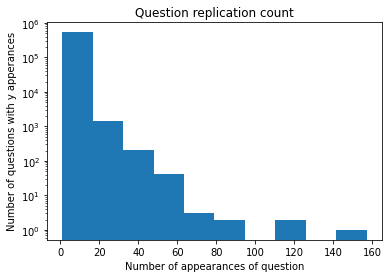

In [43]:
qid = pd.Series(train.qid1.to_list() + train.qid2.to_list())
qid_count = qid.value_counts()
print("Number of unique questions: ", len(qid_count))
plt.figure()
plt.hist(qid_count)
plt.yscale('log')
plt.title('Question replication count')
plt.xlabel('Number of appearances of question')
plt.ylabel('Number of questions with y apperances')

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set  = train_test_split(train, test_size = 0.2)

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_words = stopwords.words('english')

In [15]:
# https://www.kaggle.com/currie32/the-importance-of-cleaning-text/notebook?select=train.csv.zip
# I modified the function to fit our need
def text_to_wordlist(text, remove_stop_words=True, stem_words=False):
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [16]:
def substitute_thousands(text):
    matches = re.finditer(r'[0-9]+(?P<thousands>\s{0,2}k\b)', text, flags=re.I)
    result = ''
    len_offset = 0
    for match in matches:
        result += '{}000'.format(text[len(result)-len_offset:match.start('thousands')])
        len_offset += 3 - (match.end('thousands') - match.start('thousands'))
    result += text[len(result)-len_offset:]
    return result

In [17]:
def process_questions(question_list, questions):
    '''transform questions and display progress'''
    for question in questions:
      try:
        question_list.append(list(substitute_thousands(text_to_wordlist(question)).split(" ")))
      except:
        print(question)

In [18]:
print(train_set[:10])

            id  ...  is_duplicate
346941  346941  ...             1
386962  386962  ...             1
314139  314139  ...             1
59845    59845  ...             1
390553  390553  ...             1
53346    53346  ...             1
207081  207081  ...             1
367435  367435  ...             1
77412    77412  ...             0
303183  303183  ...             0

[10 rows x 6 columns]


In [26]:
anomaly = []
for i in range(len(train.question1)):
  if len(train.question1[i]) > 50 or len(train.question2[i]) > 50:
    continue
  for c in train.question1[i]:
    if ord(c) >= 128:
      print(train.question1[i])
      print(train.question2[i])
      print()
      anomaly.append((train.question1[i], train.question2[i]))
      break
  if len(anomaly) > 4:
    break 
# preprocess results for anomaly
for i in anomaly:
  print(substitute_thousands(text_to_wordlist(i[0])))
  print(substitute_thousands(text_to_wordlist(i[1])))
  print()

When do you use シ instead of し?
When do you use "&" instead of "and"?

What’s the best time to have sex?
When will the best time for having sex?

What is the best quote you’ve heard?
What is a good quote you have heard today?

How difficult is it to hack Pokémon GO?
What is the best Pokemon GO hack?

What is your New Year’s Resolution(s) for 2017?
What can be my new year resolution for 2017?

When use instead
When use instead

What best time sex
When best time sex

What best quote heard
What good quote heard today

How difficult hack Pok mon GO
What best Pokemon GO hack

What New Year Resolution 2017
What new year resolution 2017



In [ ]:
train_q1 = []
train_q2 = []
process_questions(train_q1, train_set.question1)
process_questions(train_q2, train_set.question2)
print(train_q1[:10])
print(train_q2[:10])

[['For', 'almost', 'year', 'I', 'practicing', 'Competitive', 'Programming', 'I', 'love', 'This', 'time', 'I', 'would', 'like', 'something', 'real', 'How', 'I', 'get', 'started', 'sophisticated', 'programming', 'build', 'projects'], ['What', 'frequently', 'asked', 'basic', 'complex', 'queries', 'SQL', 'tech', 'interview'], ['What', 'best', 'economic', 'perfume', 'men', 'India'], ['Is', 'yeshyip', 'com', 'legit'], ['What', 'Hilary', 'Clinton', 'aim', 'achieve', 'first', '100', 'days', 'POTUS'], ['Scooby', 'Doo', 'What', 'reasons', 'Shaggy', 'pothead', 'theory', 'popular', 'online'], ['What', 'relationship', 'differences', 'Keepass', 'KeepassX'], ['Is', 'Hawaii', 'state', 'country'], ['Why', 'RBI', 'issue', 'new', '2000', 'rupees', 'note'], ['What', 'review', '2013', 'Summer', 'Internships']]
[['I', 'studying', 'java', 'year', '3', 'hrs', 'day', 'programming', 'start', 'click', 'point', 'I', 'build', 'something', 'interesting'], ['Which', 'frequently', 'asked', 'interview', 'questions', '

In [ ]:
test_q1 = []
test_q2 = []
process_questions(test_q1, test_set.question1)
process_questions(test_q2, test_set.question2)
print(test_q1[:10])
print(test_q2[:10])

[['What', 'five', 'ways', 'improve', 'self', 'discipline'], ['Why', 'many', 'Indians', 'Quora', 'annoying'], ['If', 'completely', 'cover', 'aluminum', 'foil', 'still', 'get', 'sunburned'], ['Can', 'radio', 'telescope', 'intercept', 'satellite', 'communication'], ['What', 'color', 'options', 'Maruti', 'Vitara', 'Brezza'], ['Can', 'wear', 'butt', 'plug', 'day'], ['How', 'accurate', 'pregnancy', 'tests', 'Dollar', 'Tree'], ['What', 'dirtiest', 'place', 'ever'], ['Should', 'I', 'stay', 'friends', 'ex', 'even', 'though', 'I', 'hurt', 'repeatedly'], ['What', 'best', 'site', 'Internet']]
[['What', 'effective', 'ways', 'improve', 'self', 'discipline'], ['Why', 'Quora', 'popular', 'India'], ['I', 'made', 'new', 'theory', 'General', 'Relativity', 'SR', 'covering', 'flaws', 'I', 'still', '13', 'given', 'proofs', 'mathematical', 'way', 'What', 'I'], ['Can', 'NASA', 'laser', 'communication', 'satellite', 'intercepted', 'tapped'], ['Which', 'car', 'better', 'Brezza', 'KUV', '100'], ['How', 'I', 'get

In [ ]:
# convert to bagofwords representation
bow = corpora.Dictionary(train_q1 + train_q2)
bow.filter_extremes()
bow.compactify()
print(len(bow.token2id))

31313


In [ ]:
from gensim.matutils import corpus2csc
num_terms = len(bow.token2id)
train_q1_sparse = corpus2csc([bow.doc2bow(q) for q in train_q1], num_terms=num_terms).transpose() # corpus2csc has documents as columns
train_q2_sparse = corpus2csc([bow.doc2bow(q) for q in train_q2], num_terms=num_terms).transpose()
print(train_q1_sparse.shape)
print(train_q2_sparse.shape)

(323429, 31313)
(323429, 31313)


In [ ]:
test_q1_sparse = corpus2csc([bow.doc2bow(q) for q in test_q1], num_terms=num_terms).transpose()
test_q2_sparse = corpus2csc([bow.doc2bow(q) for q in test_q2], num_terms=num_terms).transpose()
print(test_q1_sparse.shape)
print(test_q2_sparse.shape)

(80858, 31313)
(80858, 31313)


In [ ]:
def get_distances(q1_sparse, q2_sparse):
  cos = []
  manhattan = []
  euclidean = []
  for i in range(q1_sparse.shape[0]):
    if i % 10000 == 0:
      print(i)
    cos.append(cosine_similarity(q1_sparse[i], q2_sparse[i])[0][0])
    manhattan.append(manhattan_distances(q1_sparse[i], q2_sparse[i])[0][0])
    euclidean.append(euclidean_distances(q1_sparse[i], q2_sparse[i])[0][0])
  return {"cos" : cos, "man" : manhattan, "eu" : euclidean}


In [ ]:
X_train = pd.DataFrame(get_distances(train_q1_sparse, train_q2_sparse));
y_train = train_set.is_duplicate;

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000


In [ ]:
X_test = pd.DataFrame(get_distances(test_q1_sparse, test_q2_sparse));
y_test = test_set.is_duplicate;

0
10000
20000
30000
40000
50000
60000
70000
80000


In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("The log loss of our random forest model is: ", log_loss(y_test, pred))

The log loss of our random forest model is:  10.780626598305174


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(y_test, pred) * 100)

Accuracy is  68.78725667219075
